<a href="https://colab.research.google.com/github/CellerCity/DiseaseClassifcation_3_BTECH/blob/main/CNN%20%26%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ul>
<li><a href="https://physionet.org/content/vindr-pcxr/1.0.0/">Dataset</a></li>
<li><a href="https://paperswithcode.com/paper/vindr-pcxr-an-open-large-scale-chest">Paper</a></li>
</ul>

####Installing necessary libraries

In [ ]:
!pip install tensorflow
!pip install pylibjpeg
!pip install pydicom
!pip install pylibjpeg-libjpeg
!pip install h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 23.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 27.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


####Initialization and imports

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [ ]:
%cd '/content/gdrive/MyDrive/vindr-pcxr'

/content/gdrive/MyDrive/vindr-pcxr


In [ ]:
import matplotlib.pyplot as plt
import pydicom                                       
from pydicom.data import get_testdata_files
import pandas as pd
import numpy as np
import os
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from PIL import Image
import cv2
from keras.models import Sequential, model_from_json, load_model
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.image import array_to_img
from IPython.display import display, clear_output
import time

##CNN

####Loading the test & train labels

In [ ]:
train_labels = pd.read_csv("image_labels_train.csv")
test_labels = pd.read_csv("image_labels_test.csv")

train_labels.head()
test_labels.head()
del train_labels["rad_ID"]
del test_labels["rad_ID"]

In [ ]:
column_names = list(train_labels.columns)
print(column_names) 
diseases = column_names[1:]
print(diseases)

['image_id', 'No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor']
['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor']


In [ ]:
y_test = test_labels[column_names[1:]].values
print(y_test)
print (y_test[0])

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Getting the frequency distribution of disease in test data
test_diseaseDistribution = dict.fromkeys(diseases, 0)
print(test_diseaseDistribution)

for i in range(len(y_test)):
  x = np.argmax(y_test[i])
  test_diseaseDistribution[diseases[x]] += 1

print(test_diseaseDistribution)

{'No finding': 0, 'Bronchitis': 0, 'Brocho-pneumonia': 0, 'Other disease': 0, 'Bronchiolitis': 0, 'Situs inversus': 0, 'Pneumonia': 0, 'Pleuro-pneumonia': 0, 'Diagphramatic hernia': 0, 'Tuberculosis': 0, 'Congenital emphysema': 0, 'CPAM': 0, 'Hyaline membrane disease': 0, 'Mediastinal tumor': 0, 'Lung tumor': 0}
{'No finding': 917, 'Bronchitis': 174, 'Brocho-pneumonia': 69, 'Other disease': 74, 'Bronchiolitis': 85, 'Situs inversus': 1, 'Pneumonia': 77, 'Pleuro-pneumonia': 0, 'Diagphramatic hernia': 0, 'Tuberculosis': 0, 'Congenital emphysema': 0, 'CPAM': 0, 'Hyaline membrane disease': 0, 'Mediastinal tumor': 0, 'Lung tumor': 0}


In [ ]:
diseases_to_be_considered = list()

for d,c in test_diseaseDistribution.items():
  if c == 0:
    continue
  diseases_to_be_considered.append(d)

print(diseases_to_be_considered)
print(len(diseases_to_be_considered))

['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia']
7


In [ ]:
y_train = train_labels[column_names[1:]].values
print(y_train)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
# print(len(y_train[0]))
# print(np.argmax(y_train[0]))

# Getting the frequency distribution of disease in training data
train_diseaseDistribution = dict.fromkeys(diseases, 0)
print(train_diseaseDistribution)

for i in range(len(y_train)):
  x = np.argmax(y_train[i])
  train_diseaseDistribution[diseases[x]] += 1

print(train_diseaseDistribution)



{'No finding': 0, 'Bronchitis': 0, 'Brocho-pneumonia': 0, 'Other disease': 0, 'Bronchiolitis': 0, 'Situs inversus': 0, 'Pneumonia': 0, 'Pleuro-pneumonia': 0, 'Diagphramatic hernia': 0, 'Tuberculosis': 0, 'Congenital emphysema': 0, 'CPAM': 0, 'Hyaline membrane disease': 0, 'Mediastinal tumor': 0, 'Lung tumor': 0}
{'No finding': 5197, 'Bronchitis': 842, 'Brocho-pneumonia': 508, 'Other disease': 385, 'Bronchiolitis': 434, 'Situs inversus': 9, 'Pneumonia': 332, 'Pleuro-pneumonia': 3, 'Diagphramatic hernia': 2, 'Tuberculosis': 2, 'Congenital emphysema': 1, 'CPAM': 1, 'Hyaline membrane disease': 10, 'Mediastinal tumor': 2, 'Lung tumor': 0}


In [ ]:
LESS_COUNT = 100

underRepresentedClasses = list()
for d,c in train_diseaseDistribution.items():
  if d in diseases_to_be_considered and c < LESS_COUNT:
    underRepresentedClasses.append(d)

print(underRepresentedClasses)

#only one class named 'Situs inversus' is has very less number of examples, we will use GAN to generate images for this class.

['Situs inversus']


In [ ]:
train_labels.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Situs inversus,Pneumonia,Pleuro-pneumonia,Diagphramatic hernia,Tuberculosis,Congenital emphysema,CPAM,Hyaline membrane disease,Mediastinal tumor,Lung tumor
0,6cb53aff85c71b98ad13d67a131708c6,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,40414c05687cdb156823c156967b13f0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0e4a464dfbf8abc6333c82f1b77b6455,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,f4d3fab0b71381e6b237dc36301e85a0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,b58c9b1c89978a0b1f8533b7a2ca1088,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
test_labels.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Situs inversus,Pneumonia,Pleuro-pneumonia,Diagphramatic hernia,Tuberculosis,Congenital emphysema,CPAM,Hyaline membrane disease,Mediastinal tumor,Lung tumor
0,d7e71a052a753c3f2f3e317d60177bec,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,e64d9421e78c82b5c104021a6c1b4e67,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,8a12a4352a866aaea4691dd27a99c7ae,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,30d6a0843a9792168fdc456c17a9028c,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,f22138be08a24e79cf07f6207341e5f5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def display_image_shape(filename,new_size=(512,512),image_channels=1):
    # this function returns the corresponding image pixel array( 3 dimensional ) from the given filename
    ds = pydicom.dcmread(filename)
    #ds.PhotometricInterpretation = 'YBR_FULL'
    #print(ds)

    # Check the TransferSyntaxUID to see if the image is compressed
    if ds.file_meta.TransferSyntaxUID.is_compressed:
        # Decompress the pixel data using the appropriate algorithm
        # print("Image was compressed.")
        # print("Decompressing the image...")
        ds.decompress()

    pixel_array = ds.pixel_array
    pixel_array = np.array(pixel_array,dtype=float)
    # print('Shape:', pixel_array.shape)
    # print('Data type:', pixel_array.dtype)
    # print(pixel_array)
    # plt.imshow(pixel_array)

    img = Image.fromarray((pixel_array / 256).astype('uint8'))


    # Resize the image
    resized_img = img.resize(new_size)

    # Convert the resized image back to a numpy array
    resized_array = np.array(resized_img)

    # Scale the array back to uint16 data type
    resized_array = resized_array * 256


    # Add an extra dimension with size 1 to represent the color channel

    # Stack the single channel to all three channels
    if image_channels == 3:
        img_3d = np.stack((resized_array,)*3, axis=-1)
    elif image_channels == 1:
        img_3d = np.expand_dims(resized_array, axis=2)
    return img_3d

/usr/local/lib/python3.10/dist-packages/pydicom/valuerep.py:290: UserWarning: Invalid value for VR UI: '00c3b26e8581f817b11313e81283a832'. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warnings.warn(msg)


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 160
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Digital X-Ray Image Storage - For Presentation
(0002, 0003) Media Storage SOP Instance UID      UI: 00c3b26e8581f817b11313e81283a832
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical (Process 14)
(0002, 0012) Implementation Class UID            UI: 1.2.3.4
(0002, 0013) Implementation Version Name         SH: 'OFFIS_DCMTK_364'
-------------------------------------------------
(0010, 0040) Patient's Sex                       CS: 'M'
(0010, 1010) Patient's Age                       AS: '010M'
(0010, 1030) Patient's Weight                    DS: None
(0028, 0002) Samples per Pixel                   US: 1
(0028, 0004) Photometric Interpretation          CS: 'MONOCHROME1'
(0028, 0010) Rows                                US: 1353
(0028, 

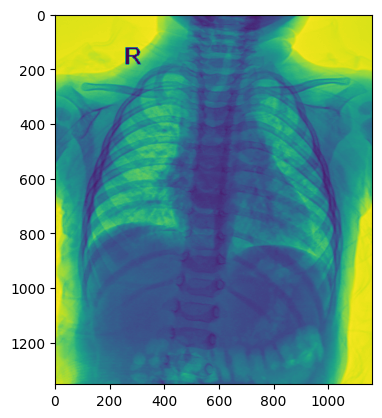

In [ ]:
ds = pydicom.dcmread("test/00c3b26e8581f817b11313e81283a832.dicom")
#ds.PhotometricInterpretation = 'YBR_FULL'
print(ds)

# Check the TransferSyntaxUID to see if the image is compressed
if ds.file_meta.TransferSyntaxUID.is_compressed:
    # Decompress the pixel data using the appropriate algorithm
    print("Image was compressed.")
    print("Decompressing the image...")
    ds.decompress()

pixel_array = ds.pixel_array
# pixel_array = np.array(pixel_array,dtype=float)
print('Shape:', pixel_array.shape)
print('Data type:', pixel_array.dtype)
print(pixel_array)
plt.imshow(pixel_array)

(1353, 1162)
(1024, 1024, 1)
Original:
 [[3642 3643 3643 ... 3640 3640 3637]
 [3640 3642 3643 ... 3637 3640 3640]
 [3654 3654 3654 ... 3640 3651 3640]
 ...
 [3734 3711 3716 ... 3776 3757 3768]
 [3723 3718 3697 ... 3775 3758 3751]
 [3732 3716 3696 ... 3751 3751 3747]]
Shape: (1353, 1162)
Resized:
 [[3584 3584 3584 ... 3584 3584 3584]
 [3584 3584 3584 ... 3584 3584 3584]
 [3584 3584 3584 ... 3584 3584 3584]
 ...
 [3584 3584 3584 ... 3584 3584 3584]
 [3584 3584 3584 ... 3584 3584 3584]
 [3584 3584 3584 ... 3584 3584 3584]]
Shape: (1024, 1024)


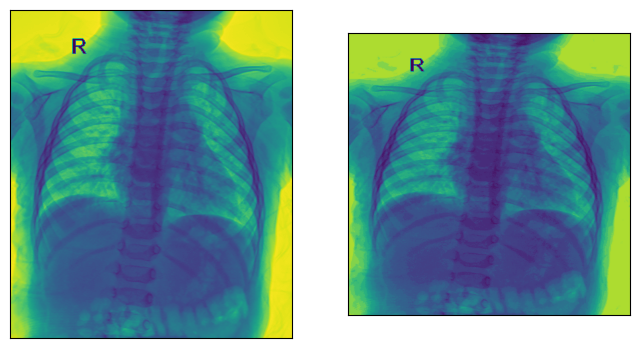

In [ ]:
# Load the DICOM image
ds = pydicom.dcmread('test/00c3b26e8581f817b11313e81283a832.dicom')

# Convert the pixel array to a numpy array
img_array = ds.pixel_array
print(img_array.shape)
# Convert the numpy array to a PIL (Python Imaging Library) Image
img = Image.fromarray((img_array / 256).astype('uint8')) 

# Set the desired size
new_size = (1024, 1024)

# Resize the image
resized_img = img.resize(new_size)

# Convert the resized image back to a numpy array
resized_array = np.array(resized_img)

# Add an extra dimension with size 1 to represent the color channel
img_3d = np.expand_dims(resized_array, axis=2)

# Check the shape of the 3D array
print(img_3d.shape)  # (256, 256, 1)

# Scale the array back to uint16 data type
resized_array = resized_array * 256
# Display the original and resized numpy arrays
print('Original:\n', img_array)
print('Shape:', img_array.shape)
print('Resized:\n', resized_array)
print('Shape:', resized_array.shape)
# plt.imshow(img_array)
# plt.imshow(resized_array)

arr = [img_array, resized_array]

plt.figure(figsize=(8,8))
for j in range(2):
    plt.subplot(1,2,j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(arr[j])
    
plt.show()

In [ ]:
test_path = "test"
train_path = "train"

In [ ]:
# Building test-labels(y_test)

y_test_l = list()
count = 0

for file in os.listdir(test_path):
    img_id = file.split('.')[0]
    
    idx = test_labels.loc[test_labels["image_id"] == img_id].index[0]
    # .loc gives the labels (row) and .index finds the index, the extra 0 is used to indicate 0 based indexing
    # print(img_id, ":",idx)
    y_test_l.append(y_test[idx])
   

    # count += 1
    # if(count == test_count):
    #     break

y_test_l = [np.argmax(pred) for pred in y_test_l]
y_test_l = np.array(y_test_l)
y_test_l = y_test_l.astype('int32')

In [ ]:
print(y_test_l)
print(type(y_test_l))
print(len(y_test_l))
print(y_test_l.dtype)

[4 0 0 ... 0 6 0]
<class 'numpy.ndarray'>
1397
int32


In [ ]:
print(len(y_test), len(y_train))
print (y_test[0])

1397 7728
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
# Building train-labels(y_train)
num_count = 0
y_train_l = list()
count = 0
# underRepresented_train_imageNames = list()

for file in os.listdir(train_path):
    img_id = file.split('.')[0]
    
    idx = train_labels.loc[train_labels["image_id"] == img_id].index[0]
    # print(img_id, ":",idx)
    y_train_l.append(y_train[idx])
    if diseases[np.argmax(y_train[idx])] in diseases_to_be_considered: 
      num_count += 1
    # if diseases[np.argmax(y_train[idx])] in underRepresentedClasses:
    #   underRepresented_train_imageNames.append(file)
    # count += 1
    # if(count == train_count):
    #     break

y_train_l = np.array(y_train_l)
y_train_l = y_train_l.astype('int32')
print(num_count)
# print(underRepresented_train_imageNames)
# print(len(underRepresented_train_imageNames))

7707


In [ ]:
# underRepresented_train_imageNames  = [os.path.join("train", name) for name in underRepresented_train_imageNames]
# print(underRepresented_train_imageNames)

In [ ]:
print(y_train_l)
print(type(y_train_l))
print(len(y_train_l))
print(y_train_l.dtype)

[[0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]]
<class 'numpy.ndarray'>
7728
int32


####Preprocessing step
Saving the dicom files as pixel representations into a directory to increase the processing speed

In [ ]:
import os
import pydicom
import numpy as np

def batch_generator(dicom_files, batch_size):
    """
    Generator function that loads DICOM files in batches and converts them to pixel arrays.
    """
    num_samples = len(dicom_files)
    num_batches = int(np.ceil(num_samples / batch_size))
    for i in range(num_batches):
        batch_start = i * batch_size
        batch_end = (i + 1) * batch_size
        batch_files = dicom_files[batch_start:batch_end]# Getting the filenames for the respective batch
        batch_images = [display_image_shape(file,new_size=(512,512),image_channels=1) for file in batch_files]
        # batch_images = np.array(batch_images)
        yield batch_images

def save_pixel_arrays(dicom_dir, pixel_array_dir, batch_size=32):
    """
    Loads DICOM files from the given directory in batches, converts them to pixel arrays, and saves them in the given directory.
    """
    if not os.path.exists(pixel_array_dir):
        os.makedirs(pixel_array_dir)[]
    dicom_files = [os.path.join(dicom_dir, file) for file in os.listdir(dicom_dir) if file.endswith('.dicom')]
    
    num_samples = len(dicom_files)
    batch_gen = batch_generator(dicom_files, batch_size) # creating an object of the generator function 
    for i, batch in enumerate(batch_gen):
        start_idx = i * batch_size
        end_idx = min(start_idx + batch_size, num_samples) # to avoid index out of bounds error
        for j in range(start_idx, end_idx):
            pixel_array_file = os.path.join(pixel_array_dir, f'{j}.npy')
            np.save(pixel_array_file, batch[j-start_idx])


In [ ]:
# don't uncomment this, it took 4 minutes
 
# save_pixel_arrays("test", "decompressed_test")

/usr/local/lib/python3.9/dist-packages/pydicom/pixel_data_handlers/pillow_handler.py:238: UserWarning: The (0028,0101) 'Bits Stored' value (12-bit) doesn't match the JPEG 2000 data (16-bit). It's recommended that you change the 'Bits Stored' value
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/pydicom/pixel_data_handlers/numpy_handler.py:217: UserWarning: The odd length pixel data is missing a trailing padding byte
  warnings.warn(


In [ ]:
# don't uncomment this, it took 1 hour
# save_pixel_arrays("train", "decompressed_train")


####Preparation before training
Image generator function<br>

In [ ]:
def myComparator(e):
  x = e.split(".")[0]
  x = x.split("/")[-1]
  return int(x)


# Load the DICOM images and their corresponding labels
train_path = "decompressed_train"
image_filenames_lst = os.listdir(train_path)
image_filenames_lst = [os.path.join(train_path,file) for file in image_filenames_lst]

print(len(image_filenames_lst))
print(type(image_filenames_lst))
print(image_filenames_lst)
print("num_count:",num_count)
print(len(y_train_l))
print() 

y_train_l_updated = list()
image_filenames_lst_updated = list()

for i in range(len(y_train_l)):
  if diseases[np.argmax(y_train_l[i])] not in diseases_to_be_considered:
    continue
  y_train_l_updated.append(y_train_l[i][:len(diseases_to_be_considered)])
  image_filenames_lst_updated.append(image_filenames_lst[i])

image_filenames_lst_updated.sort(key=myComparator) # sorting on the basis of comparator
print(image_filenames_lst_updated)

y_train_l_updated = np.array(y_train_l_updated)
# image_filenames_lst_updated = np.array(image_filenames_lst_updated)
print(len(y_train_l_updated), len(image_filenames_lst_updated))
# del y_train_l
# del image_filenames_lst

In [ ]:
print(len(y_train_l_updated[0]))
print(len(diseases_to_be_considered))
print(y_train_l_updated[:10])

7
7
[[0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 1 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]
 [1 0 0 0 0 0 0]]


In [ ]:
# y_train_l # list of one hot vector labels
new_shape = (512,512)

# Define a custom image generator function
def custom_image_generator(image_filenames_lst, one_hot_labels, batch_size,augment_data=False,new_size=(512,512),image_channels=1, inDicomFormat=True):
    num_batches = len(one_hot_labels) // batch_size
    while True:
        for batch_index in range(num_batches):  
          batch_images = []
          batch_labels = []
          image_index = 0
          for image_index in range(batch_size):
              i = batch_index * batch_size + image_index
              label = one_hot_labels[i]
              if inDicomFormat:
                image_pixel_array = display_image_shape(image_filenames_lst[i],new_size=new_size,image_channels=image_channels)
                #print(image_pixel_array.shape)
              else:
                image_pixel_array = np.load(image_filenames_lst[i])
              # if augment_data:
              #     # apply data augmentation techniques like rotation, scaling, flipping, etc.
              #     pass
              batch_images.append(image_pixel_array)
              batch_labels.append(label)
          batch_images = np.array(batch_images)
          batch_labels = np.array(batch_labels)
          yield batch_images, batch_labels


In [ ]:
print((*new_shape,1))

(512, 512, 1)


###MODEL 1 (IMAGE CHANNELS = 1)

In [ ]:
# Instantiate the custom image generator
batch_size = 32
train_generator = custom_image_generator(image_filenames_lst_updated, y_train_l_updated, batch_size, augment_data=True,image_channels=1,inDicomFormat=False)

In [ ]:
# Define the model architecture
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=((*new_shape,1))))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(diseases_to_be_considered), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 255, 255, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 64)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 128)      0

In [ ]:
# Instantiate the custom image generator
batch_size = 100

train_generator = custom_image_generator(image_filenames_lst_updated, y_train_l_updated, batch_size, augment_data=True,image_channels=1,inDicomFormat=False)

es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=5)

ckpt_mgr = tf.keras.callbacks.ModelCheckpoint(filepath='saved_models/model1_3.h5', monitor='loss', save_best_only=True, save_weights_only=False)

steps_per_epoch = len(y_train_l_updated) // batch_size
print(steps_per_epoch)

77


####Model1_3

In [ ]:
# train the model for a few epochs and save the model
model.fit(train_generator, callbacks=[es, ckpt_mgr], epochs=2,steps_per_epoch=steps_per_epoch)

Epoch 1/2
77/77 [==============================] - 76s 780ms/step - loss: 17244.5352 - accuracy: 0.5858
Epoch 2/2
77/77 [==============================] - 91s 1s/step - loss: 1.2582 - accuracy: 0.6714


In [ ]:
model = load_model('saved_models/model1_3.h5')

model.fit(train_generator, callbacks=[es, ckpt_mgr], epochs=10,steps_per_epoch=steps_per_epoch, initial_epoch=2)

Epoch 3/10
77/77 [==============================] - 60s 769ms/step - loss: 1.1487 - accuracy: 0.6779
Epoch 4/10
77/77 [==============================] - 95s 1s/step - loss: 0.9658 - accuracy: 0.7043
Epoch 5/10
77/77 [==============================] - 89s 1s/step - loss: 0.7950 - accuracy: 0.7652
Epoch 6/10
77/77 [==============================] - 59s 761ms/step - loss: 0.8367 - accuracy: 0.7913
Epoch 7/10
77/77 [==============================] - 56s 724ms/step - loss: 3.3079 - accuracy: 0.7096
Epoch 8/10
77/77 [==============================] - 56s 729ms/step - loss: 44.0461 - accuracy: 0.5492
Epoch 9/10
77/77 [==============================] - 57s 735ms/step - loss: 4.8476 - accuracy: 0.6682
Epoch 10/10
77/77 [==============================] - 62s 804ms/step - loss: 1.2200 - accuracy: 0.6742
Epoch 10: early stopping


###Performance

<pre>
The validation_split is a value between 0 and 1 and defines the percentage 
amount of the training dataset to use for the validation dataset the model
 is not trained on the validation dataset. Instead, the model is evaluated on 
 the validation dataset at the end of each training epoch.
</pre>

In [ ]:
def print_model_metrics(y_pred,y_test_l=y_test_l):
    

    # Calculate the f1 score
    f1_s = classification_report(y_test_l[:len(y_pred)], y_pred)
    print("F1-score:-\n",f1_s)

    # Calculate the accuracy
    accuracy = np.mean(y_test_l[:len(y_pred)] == y_pred)
    print("Accuracy:",accuracy)
    precision = precision_score(y_test_l, y_pred, average='macro')
    recall = recall_score(y_test_l, y_pred, average='macro')
    print("Precision:", precision)
    print("Recall:", recall)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_test_l[:len(y_pred)], y_pred)
    print(cm)

    f1 = f1_score(y_test_l[:len(y_pred)], y_pred, average='weighted')
    print('Weighted F1 score:', f1)


    #ROC
    fpr, tpr, thresholds = roc_curve(y_test_l[:len(y_pred)], y_pred, pos_label=2)
    roc_auc = auc(fpr, tpr)


    # plot the ROC curve
    plt.figure(figsize=(8,8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
##  PERFORMANCE METRICS 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from tensorflow.keras.models import load_model
from sklearn.metrics import f1_score

# collecting the test_ as appropriate for the given model
test_path = "decompressed_test"
x_test = list()
for file in os.listdir(test_path):
    file_path = os.path.join(test_path,file)
    # pixel_array = display_image_shape(file_path,image_channels=1)
    pixel_array = np.load(file_path)
    x_test.append(pixel_array)

x_test = np.array(x_test)

In [ ]:
print(type(x_test))
print(x_test.shape)

<class 'numpy.ndarray'>
(1397, 512, 512, 1)


In [ ]:
# load the saved model
model = load_model("saved_models/model1_3.h5")
batch_size = 100
num_predict = len(x_test) // batch_size
# predictions = model.predict(np.array(x_test[:num_predict*batch_size]))
predictions = model.predict(np.array(x_test))
print(predictions)
print(len(predictions))

# converting the predictions into simple labels
y_pred = list()
for lst in predictions:
    pos = np.argmax(lst)
    ans_lst = [0 for i in range(len(lst))]
    ans_lst[pos] = 1
    y_pred.append(ans_lst)

y_pred = np.array([np.argmax(pred) for pred in predictions])
del predictions

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


44/44 [==============================] - 16s 134ms/step
[[9.8431826e-01 6.8636253e-03 4.6562813e-03 ... 3.9640777e-03
  2.0315281e-11 1.2708138e-04]
 [9.0789133e-01 1.0563535e-02 4.4077292e-02 ... 3.7466645e-02
  2.5774825e-11 1.0490112e-06]
 [8.4567916e-01 1.0041645e-02 3.2748632e-02 ... 1.1150405e-01
  1.8894649e-12 2.5171978e-05]
 ...
 [9.0117419e-01 9.6774817e-02 9.2232794e-06 ... 1.7197978e-03
  8.6284533e-13 1.2075182e-05]
 [3.1289279e-01 1.6197221e-01 4.6752345e-02 ... 3.1286940e-01
  3.1431616e-10 1.6485415e-01]
 [9.1876930e-01 4.1868649e-03 3.9902188e-02 ... 3.3653367e-02
  3.0323517e-07 2.7373263e-03]]
1397


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classif

F1-score:-
               precision    recall  f1-score   support

           0       0.66      0.94      0.78       917
           1       0.11      0.03      0.05       174
           2       0.09      0.01      0.03        69
           3       0.00      0.00      0.00        74
           4       0.11      0.02      0.04        85
           5       0.00      0.00      0.00         1
           6       0.00      0.00      0.00        77

    accuracy                           0.62      1397
   macro avg       0.14      0.14      0.13      1397
weighted avg       0.46      0.62      0.52      1397

Accuracy: 0.6241947029348605
Precision: 0.13853639368513512
Recall: 0.14413723327205835
[[864  29   7   4   8   0   5]
 [163   5   1   2   3   0   0]
 [ 66   1   1   0   1   0   0]
 [ 63   6   2   0   3   0   0]
 [ 79   4   0   0   2   0   0]
 [  1   0   0   0   0   0   0]
 [ 75   1   0   0   1   0   0]]
Weighted F1 score: 0.5183572767665292


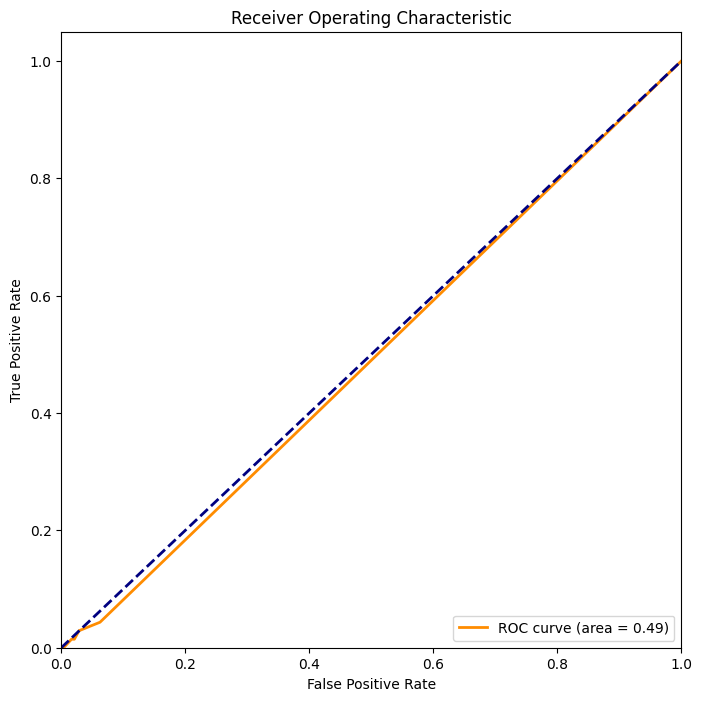

In [ ]:
print_model_metrics(y_pred,y_test_l=y_test_l)

##GAN

#### Global functions for all the tries

In [ ]:
# new_shape = (512,512)

# Define a custom image generator function
# which currently gives only all the images from the train directory & test directory
def gan_train_image_generator(image_filenames_lst, batch_size=32,augment_data=False,new_size=(512,512),image_channels=1,inDicomFormat=True):
    
    num_batches = len(image_filenames_lst) // batch_size
    while True:
        for batch_index in range(num_batches):  
          batch_images = []
          image_index = 0
          for image_index in range(batch_size):
              i = batch_index * batch_size + image_index
              if inDicomFormat:
                image_pixel_array = display_image_shape(image_filenames_lst[i],new_size=new_size,image_channels=image_channels)
                #print(image_pixel_array.shape)
              else:
                image_pixel_array = np.load(image_filenames_lst[i])
              if augment_data:
                  # apply data augmentation techniques like rotation, scaling, flipping, etc.
                  pass
              batch_images.append(image_pixel_array)
          batch_images = np.array(batch_images)
          yield batch_images

# steps_per_epoch = len(images_filenames_lst) // batch_size

In [ ]:
def myComparator(e):
  x = e.split(".")[0]
  x = x.split("/")[-1]
  return int(x)

train_path = "decompressed_train"
train_images_names = os.listdir(train_path)
train_images_names = [os.path.join(train_path,file) for file in train_images_names]
train_images_names.sort(key=myComparator)
print(train_images_names)
print(len(train_images_names))

test_path = "decompressed_test"
test_images_names = os.listdir(test_path)
test_images_names = [os.path.join(test_path,file) for file in test_images_names]
test_images_names.sort(key=myComparator)
print(test_images_names)
print(len(test_images_names))

images_filenames_lst = [*train_images_names, *test_images_names]

print(images_filenames_lst)
print(len(images_filenames_lst))

del test_images_names
del train_images_names

['decompressed_train/0.npy', 'decompressed_train/1.npy', 'decompressed_train/2.npy', 'decompressed_train/3.npy', 'decompressed_train/4.npy', 'decompressed_train/5.npy', 'decompressed_train/6.npy', 'decompressed_train/7.npy', 'decompressed_train/8.npy', 'decompressed_train/9.npy', 'decompressed_train/10.npy', 'decompressed_train/11.npy', 'decompressed_train/12.npy', 'decompressed_train/13.npy', 'decompressed_train/14.npy', 'decompressed_train/15.npy', 'decompressed_train/16.npy', 'decompressed_train/17.npy', 'decompressed_train/18.npy', 'decompressed_train/19.npy', 'decompressed_train/20.npy', 'decompressed_train/21.npy', 'decompressed_train/22.npy', 'decompressed_train/23.npy', 'decompressed_train/24.npy', 'decompressed_train/25.npy', 'decompressed_train/26.npy', 'decompressed_train/27.npy', 'decompressed_train/28.npy', 'decompressed_train/29.npy', 'decompressed_train/30.npy', 'decompressed_train/31.npy', 'decompressed_train/32.npy', 'decompressed_train/33.npy', 'decompressed_train/34.

In [ ]:
temp = np.load("decompressed_test/1.npy")
print(type(temp))
# print(temp)
print(temp.shape)

<class 'numpy.ndarray'>
(512, 512, 1)


####Try-1(Following the documentation) 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, BatchNormalization, LeakyReLU, Conv2D, Flatten, Dropout, UpSampling2D

def build_generator():
    model = Sequential()

    # Initial dense layer
    model.add(Dense(32*32*32, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((32, 32, 32)))

    # Transposed convolutional layers
    model.add(Conv2DTranspose(32, (3,3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(32, (3,3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(32, (3,3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv2DTranspose(32, (3,3), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))

    # Output layer
    model.add(Conv2DTranspose(1, (3,3), activation='sigmoid', padding='same'))

    return model



test_generator = build_generator()
test_generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             3309568   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 32)       9248      
 nspose)                                                         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 32)       128       
 ormalization)                                                   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 32)        0

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_discriminator(input_shape=(512, 512, 1)):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    return model


test_discriminator = build_discriminator(input_shape=(512,512,1))
test_discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 16)      160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 64, 64, 64)      

In [ ]:
EPOCHS = 2000
noise_dim = 100
num_examples_to_generate = 10
BATCH_SIZE = 10
# You will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed2 = tf.random.normal([1, noise_dim])

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    # 1 -> discriminator identifies the image as fake 
    # 0 -> discriminator identifies the image as real
    # So two losses
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # loss is only when the generator produces an image that is classified as fake by the discriminator
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=test_generator,
                                 discriminator=test_discriminator)
checkpoint_manager = tf.train.CheckpointManager(checkpoint, directory=checkpoint_dir, max_to_keep=3)

# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # input to the generator

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = test_generator(noise, training=True)

      real_output = test_discriminator(images, training=True) # images correspond to the real images
      fake_output = test_discriminator(generated_images, training=True) # generated_images are the artificial ones generated by the generator

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    # calculating gradients with respect to each parameter of the generator and discriminator
    gradients_of_generator = gen_tape.gradient(gen_loss, test_generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, test_discriminator.trainable_variables)

    # applying gradient descent and updating the parameters
    generator_optimizer.apply_gradients(zip(gradients_of_generator, test_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, test_discriminator.trainable_variables))

def generate_and_save_images(model, epoch, test_input,plot=False,saveImg=True):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    predictions.numpy()

    if plot:
        fig = plt.figure(figsize=(20, 20))
        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0])
            plt.axis('off')
        plt.show()

    if saveImg:
        for i in range(predictions.shape[0]):
            img = array_to_img(predictions[i])
            img.save(os.path.join('images', 'image_at_epoch_{:04d}_{}.png'.format(epoch,i)) )

def train(img_gen_obj, epochs,steps_per_epoch,s=0):
    for epoch in range(epochs):
        start = time.time()

        # train_step(next(img_gen_obj))
        for step in range(steps_per_epoch):
            # start_step = time.time()

            train_step(next(img_gen_obj))
            
            # print(f"Epoch-{epoch+1+s} step-{step+1} completed.")
            # print ('Time for epoch-{} step-{} is {} sec'.format(epoch + 1+s, step + 1, time.time()-start_step))
            

        # Produce images for the GIF as you go
        # clear_output(wait=True)
        generate_and_save_images(test_generator, epoch + 1+s, seed2)

        # we will be greedy and save after each epoch, keeping the latest 3 in the storage and deleting all the previous ones 
        checkpoint_manager.save()

        print ('Time for epoch {} is {} sec'.format(epoch + 1+s, time.time()-start))

    # Generate after the final epoch
    #   clear_output(wait=True)
    generate_and_save_images(test_generator, epochs+s, seed2,plot=True)


/usr/local/lib/python3.9/dist-packages/tensorflow/python/data/ops/structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 2s 2s/step
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


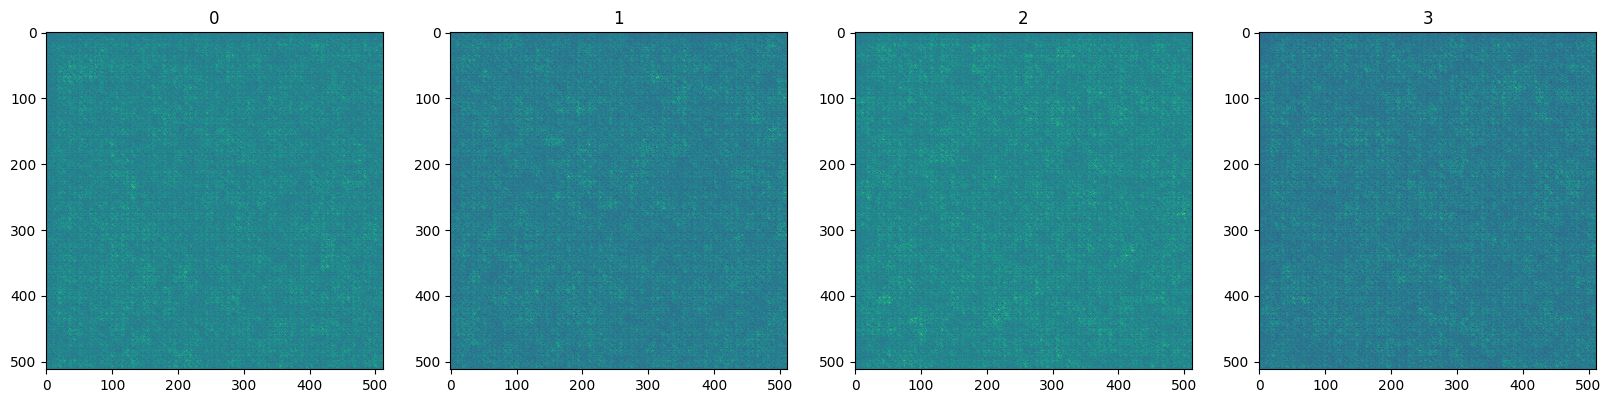

In [ ]:
#before training
#Generating images without training the model
img = test_generator.predict(np.random.randn(4,100,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)
    print(img.shape)

In [ ]:
steps_per_epoch = len(images_filenames_lst) // BATCH_SIZE
print(steps_per_epoch)

912


####Training after converting the dataset into .npy format and using a new image generator function

In [ ]:
# checkpoint.restore(checkpoint_manager.latest_checkpoint)
gan_image_generator2 = gan_train_image_generator(images_filenames_lst,batch_size=BATCH_SIZE,image_channels=1, new_size=(512,512),inDicomFormat=False)
train(gan_image_generator2, epochs=EPOCHS,steps_per_epoch=steps_per_epoch, s=0)

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 1 is 12007.54976272583 sec
Time for epoch 2 is 11121.297179222107 sec
Time for epoch 3 is 11163.931431770325 sec


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-38-327f5ac4f8cc>", line 3, in <module>
    train(gan_image_generator2, epochs=EPOCHS,steps_per_epoch=steps_per_epoch, s=0)
  File "<ipython-input-35-1d35fcdbf626>", line 72, in train
    train_step(next(img_gen_obj))
  File "<ipython-input-29-4b374e7a2d59>", line 18, in gan_train_image_generator
    image_pixel_array = np.load(image_filenames_lst[i])
  File "/usr/local/lib/python3.9/dist-packages/numpy/lib/npyio.py", line 407, in load
    fid = stack.enter_context(open(os_fspath(file), "rb"))
OSError: [Errno 107] Transport endpoint is not connected: 'decompressed_train/1355.npy'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.9/dist-packages/IPython/core/interactiveshell.py", line 2040,

OSError: ignored

In [ ]:
checkpoint.restore(checkpoint_manager.latest_checkpoint)
gan_image_generator2 = gan_train_image_generator(images_filenames_lst,batch_size=BATCH_SIZE,image_channels=1, new_size=(512,512),inDicomFormat=False)
train(gan_image_generator2, epochs=EPOCHS,steps_per_epoch=steps_per_epoch, s=3)

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 4 is 862.4248547554016 sec
Time for epoch 5 is 451.9027347564697 sec
Time for epoch 6 is 450.3031487464905 sec
Time for epoch 7 is 448.4789342880249 sec


In [ ]:
checkpoint.restore(checkpoint_manager.latest_checkpoint)
gan_image_generator2 = gan_train_image_generator(images_filenames_lst,batch_size=BATCH_SIZE,image_channels=1, new_size=(512,512),inDicomFormat=False)
train(gan_image_generator2, epochs=EPOCHS,steps_per_epoch=steps_per_epoch, s=7)

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 8 is 2211.499577999115 sec
Time for epoch 9 is 442.0057020187378 sec
Time for epoch 10 is 444.7823784351349 sec
Time for epoch 11 is 473.21518182754517 sec
Time for epoch 12 is 474.18273997306824 sec
Time for epoch 13 is 444.2106771469116 sec
Time for epoch 14 is 443.69430661201477 sec
Time for epoch 15 is 443.80848145484924 sec
Time for epoch 16 is 443.41992926597595 sec
Time for epoch 17 is 441.08153200149536 sec
Time for epoch 18 is 445.1230707168579 sec
Time for epoch 19 is 442.36785340309143 sec
Time for epoch 20 is 438.17390537261963 sec
Time for epoch 21 is 433.012939453125 sec
Time for epoch 22 is 429.3307898044586 sec


In [ ]:
checkpoint.restore(checkpoint_manager.latest_checkpoint)
gan_image_generator2 = gan_train_image_generator(images_filenames_lst,batch_size=BATCH_SIZE,image_channels=1, new_size=(512,512),inDicomFormat=False)
train(gan_image_generator2, epochs=EPOCHS,steps_per_epoch=steps_per_epoch, s=22)

/usr/local/lib/python3.9/dist-packages/keras/backend.py:5676: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


Time for epoch 23 is 707.6871798038483 sec
Time for epoch 24 is 403.33137822151184 sec
Time for epoch 25 is 403.3158378601074 sec
Time for epoch 26 is 404.00617718696594 sec
Time for epoch 27 is 403.20496129989624 sec
Time for epoch 28 is 402.9293200969696 sec
Time for epoch 29 is 402.38877415657043 sec
Time for epoch 30 is 403.020929813385 sec
Time for epoch 31 is 403.18697118759155 sec
Time for epoch 32 is 405.4360785484314 sec
Time for epoch 33 is 402.18847155570984 sec
Time for epoch 34 is 405.1465394496918 sec
Time for epoch 35 is 402.7425878047943 sec
Time for epoch 36 is 405.7045660018921 sec
Time for epoch 37 is 406.7192506790161 sec
Time for epoch 38 is 405.7429356575012 sec
Time for epoch 39 is 404.96430945396423 sec
Time for epoch 40 is 401.08086347579956 sec
Time for epoch 41 is 400.70901370048523 sec
Time for epoch 42 is 400.69760489463806 sec
Time for epoch 43 is 401.15841245651245 sec
Time for epoch 44 is 401.02911138534546 sec
Time for epoch 45 is 399.4170331954956 sec


####After training

1/1 [==============================] - 0s 34ms/step
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)
(512, 512, 1)


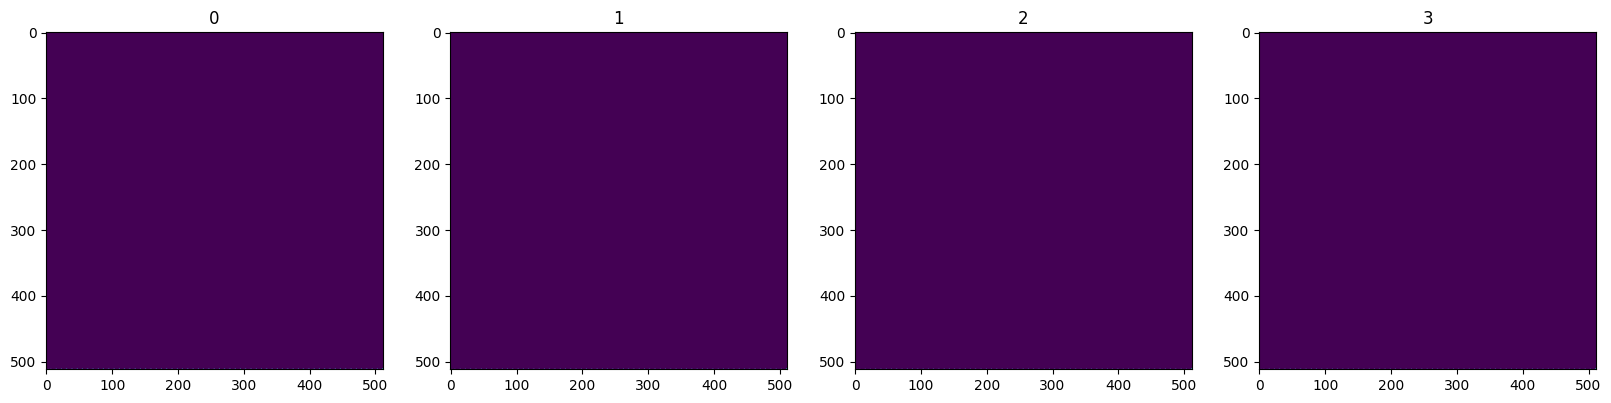

In [ ]:
#After training
checkpoint.restore(checkpoint_manager.latest_checkpoint)
#Generating images without training the model
img = test_generator.predict(np.random.randn(4,100,1))
# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop four times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    # Appending the image label as the plot title 
    ax[idx].title.set_text(idx)
    print(img.shape)